# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

## Multi-Agent Solution

- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Modifications of Deep Deterministic Policy Gradients (DDPG) notebook
---


### 1. Import the Necessary Packages

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

#from ddpg_agent_single import Agent

In [2]:
random_seed = 17
max_steps=1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



### 2. Instantiate the Environment and Agent

In [3]:
!pip -q install ./python
from unityagents import UnityEnvironment

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
    
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
state = env_info.vector_observations.squeeze()
state_size = state.shape[-1]
print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:\n', np.round(state, 3))
print('State shape: ', state.shape)

actions = []

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like:
 [  0.     -4.      0.      1.     -0.     -0.     -0.      0.      0.      0.
   0.      0.      0.      0.    -10.      0.      1.     -0.     -0.     -0.
   0.      0.      0.      0.      0.      0.      5.755  -1.      5.557
   0.      1.      0.     -0.168]
State shape:  (33,)


In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim

### Network hyperparameters
BUFFER_SIZE = int(6.4e6)  # replay buffer size = int(1e6)
BATCH_SIZE = 128           # minibatch size = 128
GAMMA = 0.995             # discount factor = 0.99
TAU = 1e-3                # for soft update of target parameters = 1e-3
LR_ACTOR = 1e-4           # learning rate of the actor  = 1e-4
LR_CRITIC = 1e-3          # learning rate of the critic = 3e-4
WEIGHT_DECAY = 1e-5       # L2 weight decay = 0.00001 to 0.



In [5]:
### Actor and Critic models

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [6]:
class ActorX(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(ActorX, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        self.batch_norm1 = nn.BatchNorm1d(fc1_units)
        self.batch_norm2 = nn.BatchNorm1d(fc2_units)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = self.batch_norm1(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)
        return torch.tanh(self.fc3(x))
    
    
class CriticX(nn.Module):
    """Critic aka Value Model. 
       (state, action) pair -> estimated reward aka Q-value
    """

    def __init__(self, state_size, action_size, seed, 
                 state_units=192, action_units=64, hidden_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            state_units (int): Number of nodes in the input layer
            action_units (int): Number of nodes in the input layer
            hidden_units (int): Number of nodes in the second hidden layer
        """
        super(CriticX, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_state = nn.Linear(state_size, state_units)
        self.fc_action = nn.Linear(action_size, action_units)
        self.fc_hidden = nn.Linear(state_units+action_units, hidden_units)
        self.fc_output = nn.Linear(hidden_units, 1)
        self.reset_parameters()
        self.batch_norm_state = nn.BatchNorm1d(state_units)
        self.batch_norm_hidden = nn.BatchNorm1d(hidden_units)

    def reset_parameters(self):
        self.fc_state.weight.data.uniform_(*hidden_init(self.fc_state))
        self.fc_action.weight.data.uniform_(*hidden_init(self.fc_action))
        self.fc_hidden.weight.data.uniform_(*hidden_init(self.fc_hidden))
        self.fc_output.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Critic network to map (state, action) pairs -> estimated rewards."""
        xs = F.relu(self.fc_state(state))
        xs = self.batch_norm_state(xs)
        xa = F.relu(self.fc_action(action))
        x = torch.cat((xs, xa), dim=1)
        x = F.relu(self.fc_hidden(x))
        x = self.batch_norm_hidden(x)
        return self.fc_output(x)

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for _ in range(len(x))])
        self.state = x + dx
        return self.state

class PriorityReplay:
    """Fixed-size buffer to store experience tuples and batch them by priority.
       Aka 'Collection of Trajectories'? 
       TO DO: priority determined by...?
    """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a PriorityReplay object.
            Params
            ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_size)  # internal memory (deque)
        self.seed = random.seed(seed)
        self.experience = namedtuple("Experience", field_names=["step", "state", "action", "reward", "next_state", "done",
                                                                "priority"])
    
    def add(self, step, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        ### Priority calculated here:
        #priority = ((1000 - step)/1000 + int(done)) * abs(reward)
        #######  TO DO just use rewards for priorities ??  Critic MSE Loss?
        priority = (1000 - step) * abs(reward)
####### print("To buffer: ", step, "\t", np.round(reward, 3), "\t", np.round(priority, 3), "\t", len(self.buffer))
        e = self.experience(step, state, action, reward, next_state, done, priority)
        self.buffer.append(e)
                    
    def norm(self, rewards):
        #rewards = [e.reward for e in experiences]
        ravg = np.mean(rewards)
        rstd = np.std(rewards)
        rsum = np.sum(rewards)
        if rstd != 0:
            normed_rewards = [(r-ravg)/rstd for r in rewards]
        else:
            normed_rewards = [r/rsum for r in rewards] 
        return normed_rewards

    def sample(self):
        """Randomly sample a batch of experiences from memory according to their relative priority."""
####### TO DO: fix priorities
        probs = [e.reward for e in self.buffer]
        experiences = random.choices(population=self.buffer, k=self.batch_size, weights=probs)
          
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
                    
        return (states, actions, normed_rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.buffer)
                    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples. (ie. "trajectories"?)"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
            Params
            ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.buffer = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["step", "state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, step, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(step, state, action, reward, next_state, done)
        self.buffer.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.buffer)
    
class PriorityBufferX:
    """Fixed-size buffer to store experience tuples. (ie. "trajectories"?)"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
            Params
            ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.buffer = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["step", "state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, step, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(step, state, action, reward, next_state, done)
        self.buffer.append(e)
       
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        probs = [e.reward for e in self.buffer]
        experiences = random.choices(population=self.buffer, k=self.batch_size, weights=probs)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def reprioritize(self, priorities, experiences):
        #for p, e in zip(priorities, experiences):
        #    e.priority = p
        pass
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.buffer)

In [8]:
random.random()

0.2129371387881267

In [10]:
### Agent made of four networks: Remote and Local Critics (values), Remote and local Actors (actions)

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, 
                 add_noise=True, priority_replay=False, learn_every=7):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            add_noise (bool): if True, add noise to action vectors
            priority_replay (bool): if working, else vanilla replay
            learn_every (int) : learning rate (between 13 and 23)
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.add_noise = add_noise  
        self.priority_replay = priority_replay
        self.learn_every = learn_every ## 
        
        # Memory: a replay buffer, or a priority replay buffer
        # Trajectory-like "experiences"
        if priority_replay:
            self.replay =  PriorityReplay(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        else: 
            self.replay = PriorityBufferX(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        ## Four networks per Agent:
        # Actor Networks: state --> action
        self.actor_local = ActorX(state_size, action_size, random_seed).to(device)     
        self.actor_target = ActorX(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Networks: state, action --> reward
        self.critic_local = CriticX(state_size, action_size, random_seed).to(device)
        self.critic_target = CriticX(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, 
                                                               weight_decay=WEIGHT_DECAY)

        # Noise to add to actions
        if self.add_noise: self.noise = OUNoise(action_size, random_seed)
        else: self.noise = None

    def reset(self):
        if self.add_noise: self.noise.reset()

    def step(self, step, state, action, reward, next_state, done):
        """ Save experience in replay memory; then
            Use a random sample from the buffer to train on.
        """        
        if len(self.replay) <= BATCH_SIZE:
            self.replay.add(step, state, action, reward, next_state, done)
#### TO DO fix repeat   add statement   
        elif reward > 0.:
            self.replay.add(step, state, action, reward, next_state, done)
            
            # Start learning from memory batches once n_experiences > batch_size
            if step % self.learn_every == 0: 
                experiences = self.replay.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state):
        """Returns actions for given state per current policy.
           "Current policy" is set by current local actor weights + some noise.
           Action values are clipped to (-1, 1) per Reacher env.
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if self.add_noise:
            action += self.noise.sample()
        return np.clip(action, -1., 1.)

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (step, s, a, r, s', done) tuples
            experiences are one batch_size in size
            gamma (float): discount factor
        """
        ### TO DO pre-normalize these parameters:
        states, actions, rewards, next_states, dones = experiences

        # --------------------------  from target models ------------------------------ #
        # Target actor predicts actions for next-state
        actions_next = self.actor_target(next_states)
        # Target critic predicts next-reward Q-values:
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Estimate expected Q-values from recorded states, actions, and rewards
        #### TO DO: Use Log() of rewards? Pre-scale to [0,1]? Pre-norm by [mean,std]?
        Q_targets = rewards + gamma * Q_targets_next * (1 - dones)
        
        # ---------------------------- update local critic ---------------------------- #
        # Compute local critic loss compared to target estimate of rewards from
        # the recorded (state, action) pairs
        Q_expected = self.critic_local(states, actions)
        critic_mse_loss = F.mse_loss(Q_expected, Q_targets)      
        # Minimize critic loss
        self.critic_optimizer.zero_grad()
        critic_mse_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update local actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize actor loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # --------------=====----- soft update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

        #### TO DO: return critic_mse_loss.tolist() for priority adjustment?

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        (tau << 0 so θ_target remains mostly θ_target)

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter << 0
        """
        for target_param, local_param in zip(target_model.parameters(), 
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



In [11]:
seed = 123
agent = Agent(state_size, action_size, seed,
              add_noise=True, priority_replay=False, learn_every=3)
#agent.actor_local.load_state_dict(torch.load('data/checkpoint_actor.pth'))
#agent.critic_local.load_state_dict(torch.load('data/checkpoint_critic.pth'))

### 3. Train the Agents with DDPG

In [12]:
env_info.vector_observations.shape

(1, 33)

In [13]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations#.squeeze()
actions = agent.act(state)
scores = env_info.rewards
#print([a for a in actions])
print(actions)
print(scores)

[[-0.01570548 -0.01936131  0.06098157  0.07291143]]
[0.0]


In [14]:
def train_agent(n_episodes=100, print_every=100, max_score=-np.inf):
    scores_deque = deque(maxlen=100)
    epi_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)
        score = 0.                                  # initialize the score (for each agent)
        step = 0.
        while True:
            step += 1
            actions = agent.act(state)                       # list-like of actions (onex4 per agent)
            env_info = env.step(actions)[brain_name]           # send all 20 actions to tne environment
            next_state = env_info.vector_observations#.squeeze()         # get next states (one per agent)
            reward = env_info.rewards[0]                         # rewards returned (for each agent)
            done = env_info.local_done[0]                        # see if any episodes are finished
            agent.step(step, state, actions, reward, next_state, done)
            state = next_state                               # roll over states to next time step
            score += reward                                  # update the score (for each agent)
            if done:                                  # exit loop if any episode finished
                break    
        scores_deque.append(score)
        epi_scores.append(score) 
        #if max(all_scores).any() > max_score: max_score = max(all_scores).any()
        epi_max = np.max(epi_scores)
        if max_score < epi_max: max_score = epi_max
        avg_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tHigh Score: {:.2f}'.format(i_episode, avg_score, max_score), end="")
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), './data/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), './data/checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}\tHigh Score: {:.2f}\n'.format(i_episode, avg_score, max_score))   

    return epi_scores, max_score     

In [15]:
scores, mx = train_agent(n_episodes=600, print_every=100)
#scores += ores
scores[-10:], mx

Episode 100	Average Score: 0.02	High Score: 0.19

Episode 200	Average Score: 0.02	High Score: 0.58

Episode 300	Average Score: 0.01	High Score: 0.58

Episode 400	Average Score: 0.01	High Score: 0.58

Episode 500	Average Score: 0.01	High Score: 0.58

Episode 600	Average Score: 0.01	High Score: 0.58



([0.0, 0.0, 0.0, 0.0, 0.1099999975413084, 0.0, 0.0, 0.0, 0.0, 0.0],
 0.57999998703598976)

In [16]:
mem = agent.replay.buffer
len(mem), mem[-1][1].shape, mem[-1][4].shape, mem[-1][-1]

(326, (1, 33), (1, 33), False)

In [17]:
steps = [m.step for m in mem]
states = [m.state for m in mem]
actions = [m.action for m in mem]
rewards = [m.reward for m in mem]
next_st = [m.next_state for m in mem]
dones = [m.done for m in mem]

steps_df = pd.DataFrame(data=steps)
states_df = pd.DataFrame(data=states)
actions_df = pd.DataFrame(data=actions)
rewards_df = pd.DataFrame(data=rewards)
next_st_df = pd.DataFrame(data=next_st)
dones_df = pd.DataFrame(data=dones)

ValueError: Must pass 2-d input

In [31]:
next_st[0]

(1, 33)

In [48]:
rewards_df.to_csv('data/rewards.csv')
steps_df.to_csv('data/steps2.csv')
actions_df.to_csv('data/actions2.csv')
states_df.to_csv('data/states2.csv')
next_st_df.to_csv('data/next_st2.csv')
dones_df.to_csv('data/dones2.csv')

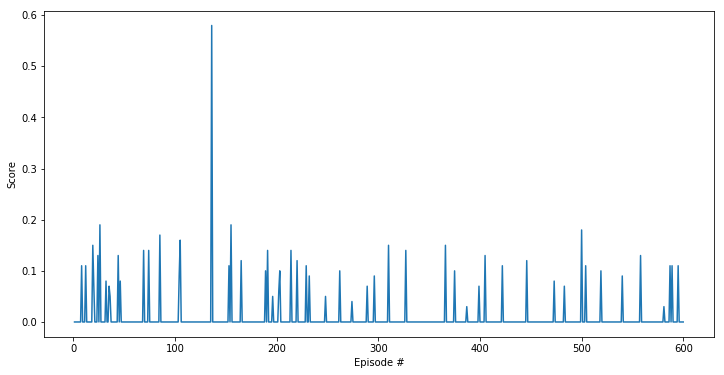

In [18]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In [22]:
agent.actor_local.load_state_dict(torch.load('./data/checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('./data/checkpoint_critic.pth'))

env_info = env.reset(train_mode=True)[brain_name]
#state = env.reset()
for t in range(200):
    action = agent.act(state)#, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

#env.close()

AttributeError: 'UnityEnvironment' object has no attribute 'render'

In [ ]:
#### Display from DQN notebook
rewards = []
steps = []
tries = 100
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
img = plt.imshow(env.render())
for j in range(1000):
    action = agent.act(state)
    state, reward, done, trun, info = env.step(action)
    rewards += [reward]
    img.set_data(env.render()) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done or trun:
        break 

In [ ]:
#env.close()